In [40]:
import aegis
import numpy as np
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
# from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
# from sbi import utils as utils
# from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle

%matplotlib inline

In [41]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [42]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen, my_AEGIS.Emin_gen, my_AEGIS.Emax_gen = angular_cut_gen, lat_cut_gen, energy_range_gen[0], energy_range_gen[1]

In [43]:
# For SFGs

def ZL(z, l, params):
    #LF (luminosity function): Output is of the form dN/dV/dlog_{10}l_erg where l_erg is the luminoisity measured in ergs. Input to LF is "log_{10}l_erg"
    if params[0] == 1: # SFG - spiral_galaxy
        with open("Phi_SFG_type_spiral_galaxy_input_logLgamma.pkl", "rb") as f:
            LF = pickle.load(f)
        E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    elif params[0] == 2: # SFG - starburst_galaxy
        with open("Phi_SFG_type_starburst_galaxy_input_logLgamma.pkl", "rb") as f:
            LF = pickle.load(f)
        E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    elif params[0] == 3: # SFG - SF_AGN
        with open("Phi_SFG_type_SF_AGN_input_logLgamma.pkl", "rb") as f:
            LF = pickle.load(f)
        E_photon = 8.09e-04 # erg # average energy of one gamma band photon for SFG # assuming gamma band is 0.1 - 1,000 GeV
    else:
        raise ValueError("Enter a valid number for params[0]: 1 - SFG (spiral glaxy); 2 - SFG (starburst_galaxy); 3 - SFG (SF_AGN)")
    
    l_erg = l * E_photon # erg/s

    return 1e-9 / np.log(10) / l * LF(np.log10(l_erg)) # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9


def spec(energy, params):
    return np.ones(np.size(energy))

als_ef = [ZL, spec]
my_AEGIS.abun_lum_spec = [als_ef]
my_AEGIS.source_class_list = ['extragalactic_isotropic_faint_single_spectrum']

Number of sources:  4537467
Number of photons:  444312
Average photon energy:  75.36649735974922  GeV
Average luminosity/source:  1.0459816590778275e+43 $ erg s^{-1}$
Approximate Flux:  4.2502336969991425e-07 $ erg cm^{-2}s^{-1}$
Size of pixels (deg): 0.9161297098179749


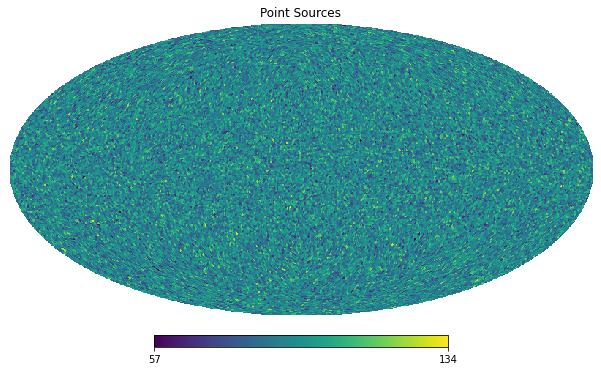

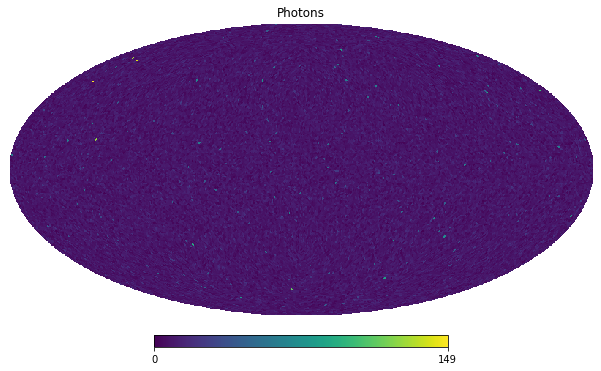

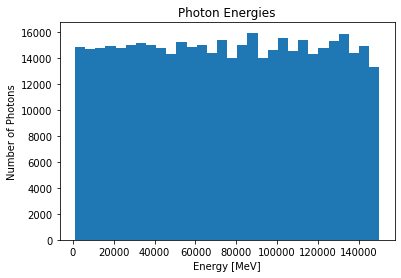

In [44]:
# 1 - spiral_galaxy
# 2 - starburst_galaxy
# 3 - SF_AGN
input_params = [3] # Choose from 1, 2, or 3


source_info = my_AEGIS.create_sources(input_params, grains =  1000, epsilon=1e-2)
photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info)

N_side = 2**6
heatmap = np.histogram(hp.ang2pix(N_side, source_info['angles'][:,0], source_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Point Sources')

heatmap = np.histogram(hp.ang2pix(N_side, photon_info['angles'][:,0], photon_info['angles'][:,1]), bins = 12*N_side**2, range = [0, 12*N_side**2])
hp.mollview(heatmap[0], title = 'Photons')

fig, ax = plt.subplots()
ax.set_title('Photon Energies')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_ylabel('Number of Photons')
ax.set_xlabel('Energy [MeV]')
ax.hist(photon_info['energies'], bins = 30, range = energy_range_gen)

print('Number of sources: ', np.size(source_info['distances']))
print('Number of photons: ', np.size(photon_info['energies']))
print('Average photon energy: ', np.mean(photon_info['energies'])/1000, ' GeV')
print('Average luminosity/source: ', np.mean(source_info['luminosities'])*np.mean(photon_info['energies'])*u.MeV.to('erg'), r'$ erg s^{-1}$')
print('Approximate Flux: ', np.mean(photon_info['energies'])*u.MeV.to('erg')*np.size(photon_info['energies'])/(exposure*u.yr.to('s')), r'$ erg cm^{-2}s^{-1}$')
print('Size of pixels (deg):', hp.nside2resol(N_side)*u.rad.to('deg'))